## deepCR style Bayesian UNet - Variational Inference

### Uncertainity-Aware Cosmic Ray Segmentation for HST ACS/WFC Photometry

#### Import all the libraries and define the base directory

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import sys
import shutil
import tarfile
import urllib
import seaborn as sns    

from model import deepCR, deepCRVI
from evaluate import roc, roc_lacosmic
from training import train
import torch


In [2]:
base_dir = os.path.join('/scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC')
print(base_dir)


/scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC


#### Initialize model training and Train the model

In [3]:
def model_train():
    # deepCR scalable HST branch
    train_dirs = np.load(os.path.join(base_dir, 'train_dirs.npy'), allow_pickle=True)

    f435_train_dirs = []
    f814_train_dirs = []
    f606_train_dirs = []

    num_trains = len(train_dirs)
    for i, train_dir in enumerate(train_dirs):
        arr = train_dir.split('/')
        _filter = arr[-4]
        if _filter == 'f435w':
            f435_train_dirs.append(train_dir)
        elif _filter == 'f606w':
            f606_train_dirs.append(train_dir)
        elif _filter == 'f814w':
            f814_train_dirs.append(train_dir)
        else:
            raise ValueError('Check filter')

    aug_sky = (-0.9, 3)

    print('------------------------------------------------------------')
    print('Training ACS/WFC Global VI model')
    print('------------------------------------------------------------')

    out_dir = os.path.join(base_dir, 'deepCR.ACS-WFC-VI1')
    os.makedirs(out_dir, exist_ok=True)

    trainer = train(
        train_dirs[::],
        mode='pair',
        aug_sky=aug_sky,
        name='ACS-WFC-VI1',
        epoch=50,
        epoch_phase0=50,
        bayesian=True,   # VI ON
        kl_beta=0.0,    # tune this
        directory=out_dir + '/'  # IMPORTANT: trainer.save() concatenates directory + filename
    )

    trainer.train()
    mdl_vi = trainer.save()  # saved as out_dir/ + mdl_vi + '.pth'

    # no shutil.move needed: file is already in out_dir
    np.save(os.path.join(out_dir, f'loss_{mdl_vi}.npy'),
            np.array(trainer.validation_loss))

    del trainer
    gc.collect()

    return mdl_vi


------------------------------------------------------------
Training ACS/WFC Global VI model
------------------------------------------------------------
Begin first 50 epochs of training
Use batch statistics for batch normalization; keep running statistics to be used in phase1

----------- epoch = 1 -----------
[TPR=0.880, FPR=0.002] @threshold = 0.5
loss = 0.0102

----------- epoch = 2 -----------
[TPR=0.878, FPR=0.001] @threshold = 0.5
loss = 0.0074

----------- epoch = 3 -----------
[TPR=0.896, FPR=0.001] @threshold = 0.5
loss = 0.0069

----------- epoch = 4 -----------
[TPR=0.894, FPR=0.001] @threshold = 0.5
loss = 0.0064

----------- epoch = 5 -----------
[TPR=0.888, FPR=0.001] @threshold = 0.5
loss = 0.0059

----------- epoch = 6 -----------
[TPR=0.868, FPR=0.001] @threshold = 0.5
loss = 0.0059

----------- epoch = 7 -----------
[TPR=0.881, FPR=0.001] @threshold = 0.5
loss = 0.0059

----------- epoch = 8 -----------
[TPR=0.884, FPR=0.001] @threshold = 0.5
loss = 0.0058

-------

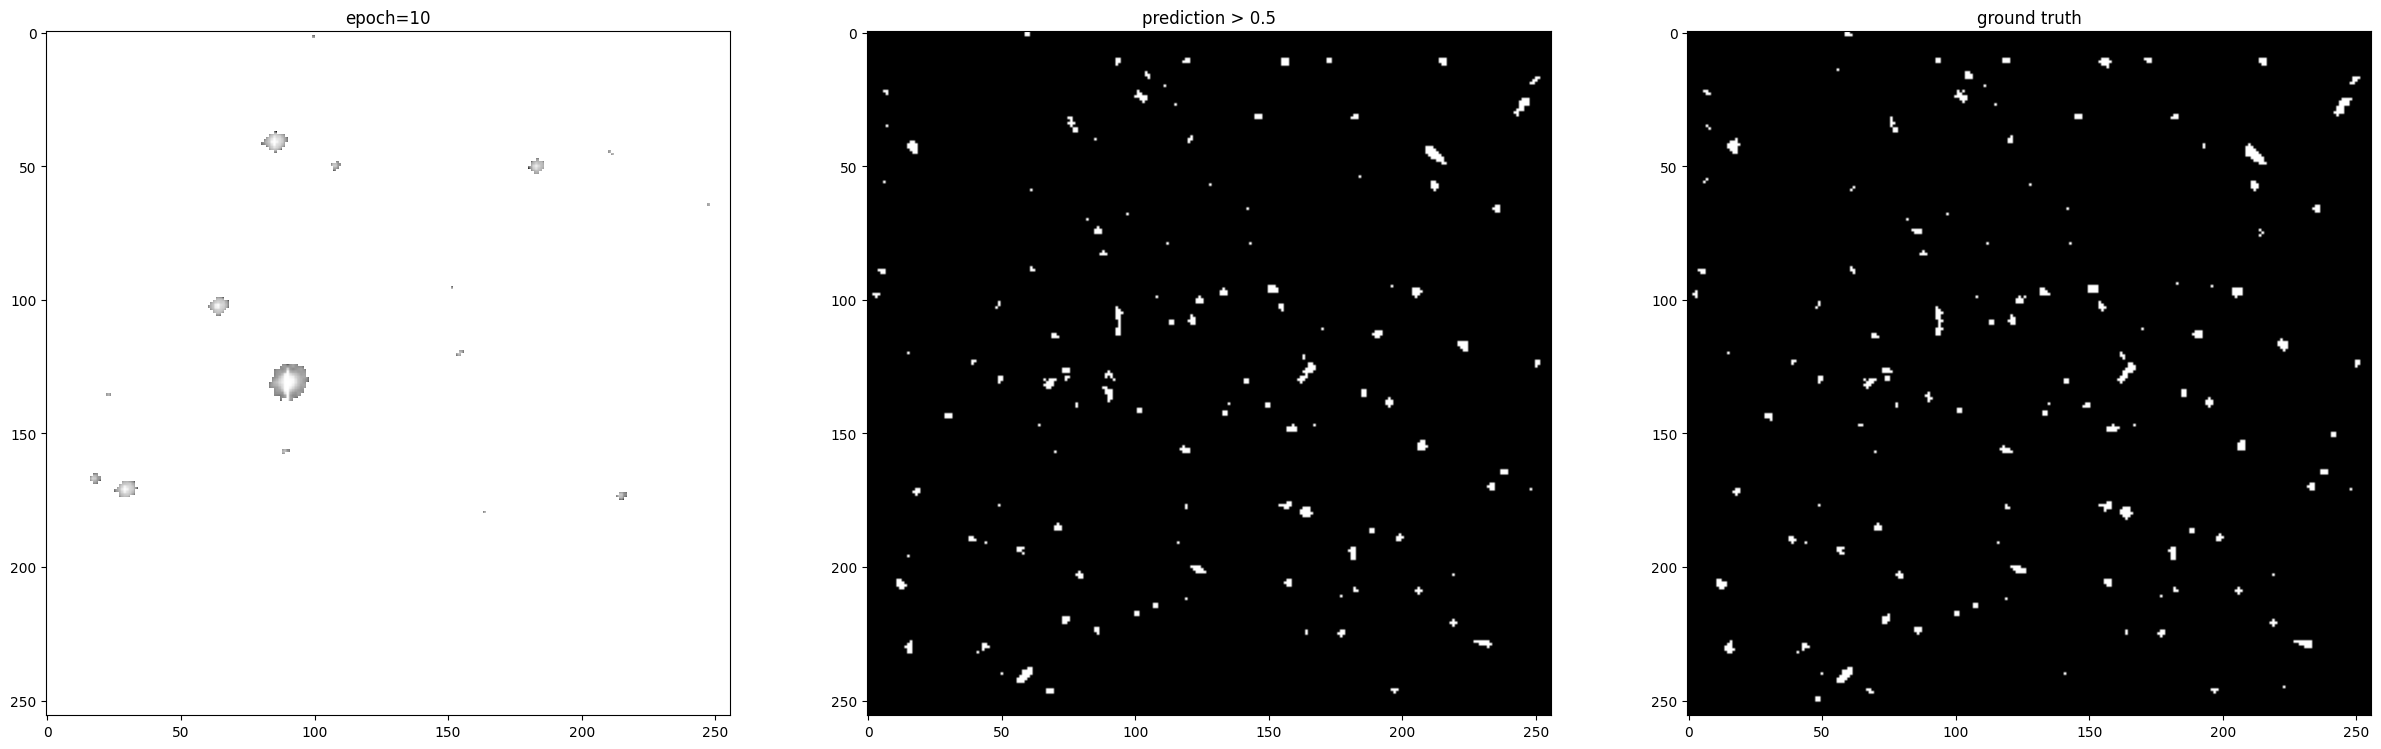

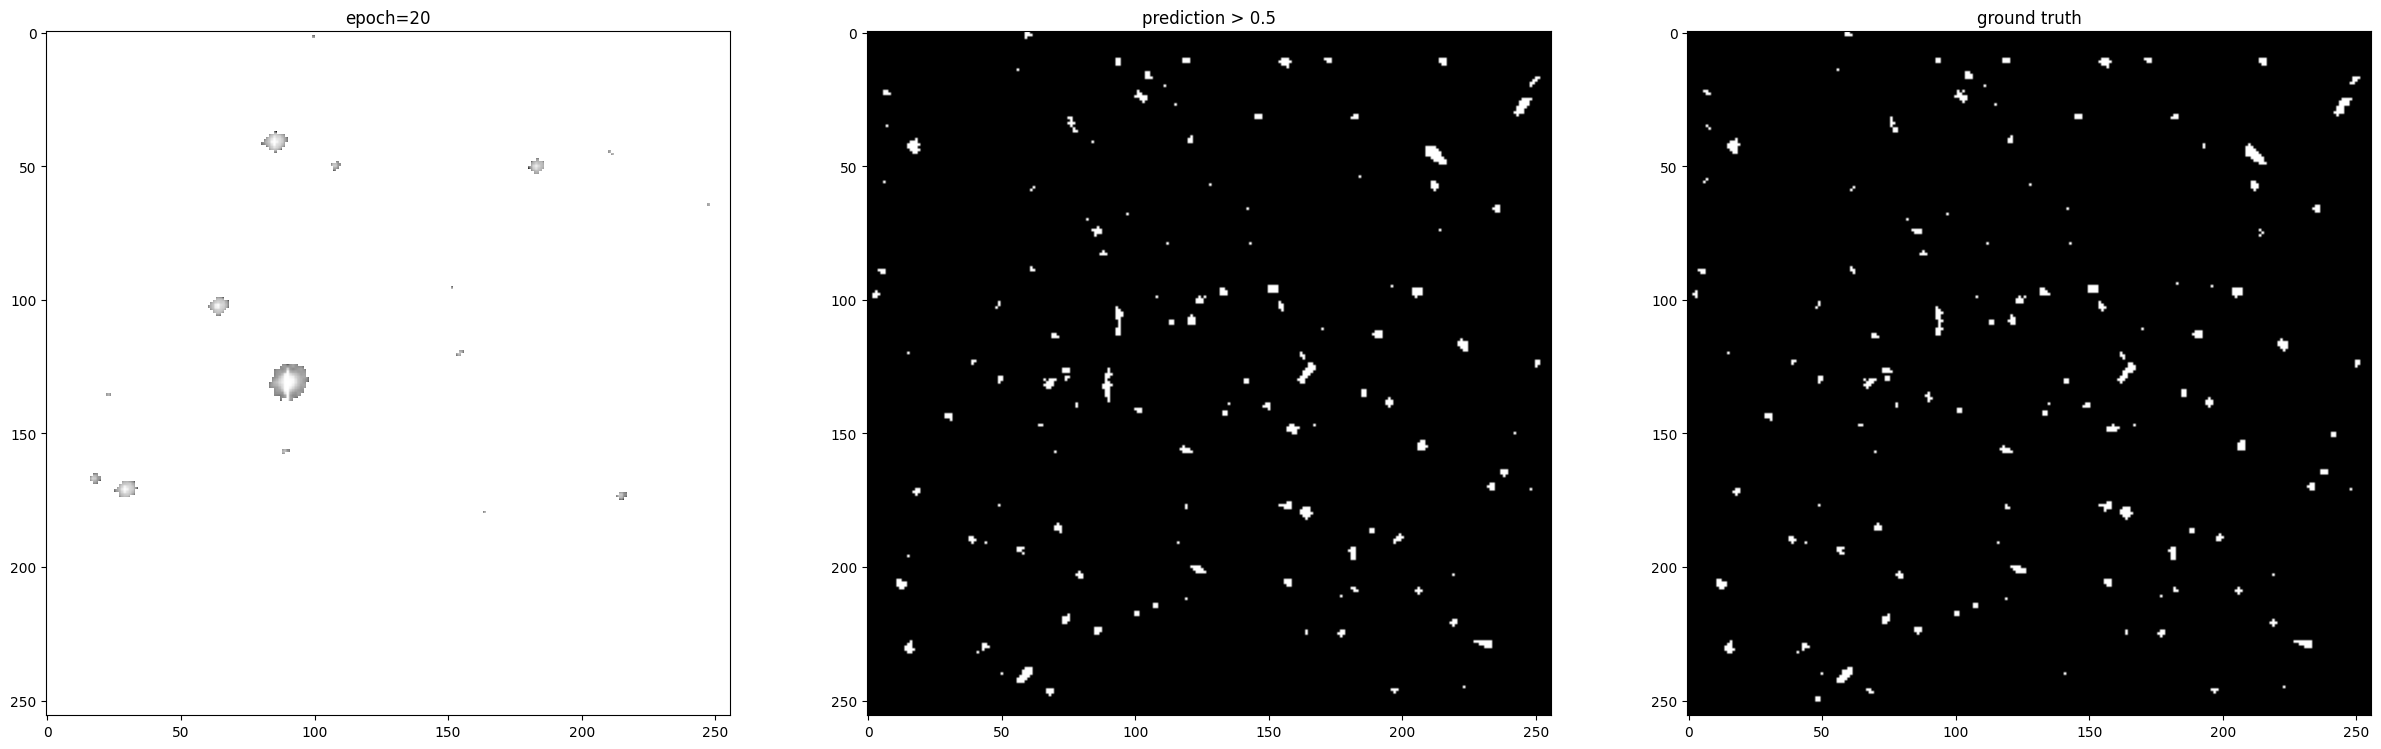

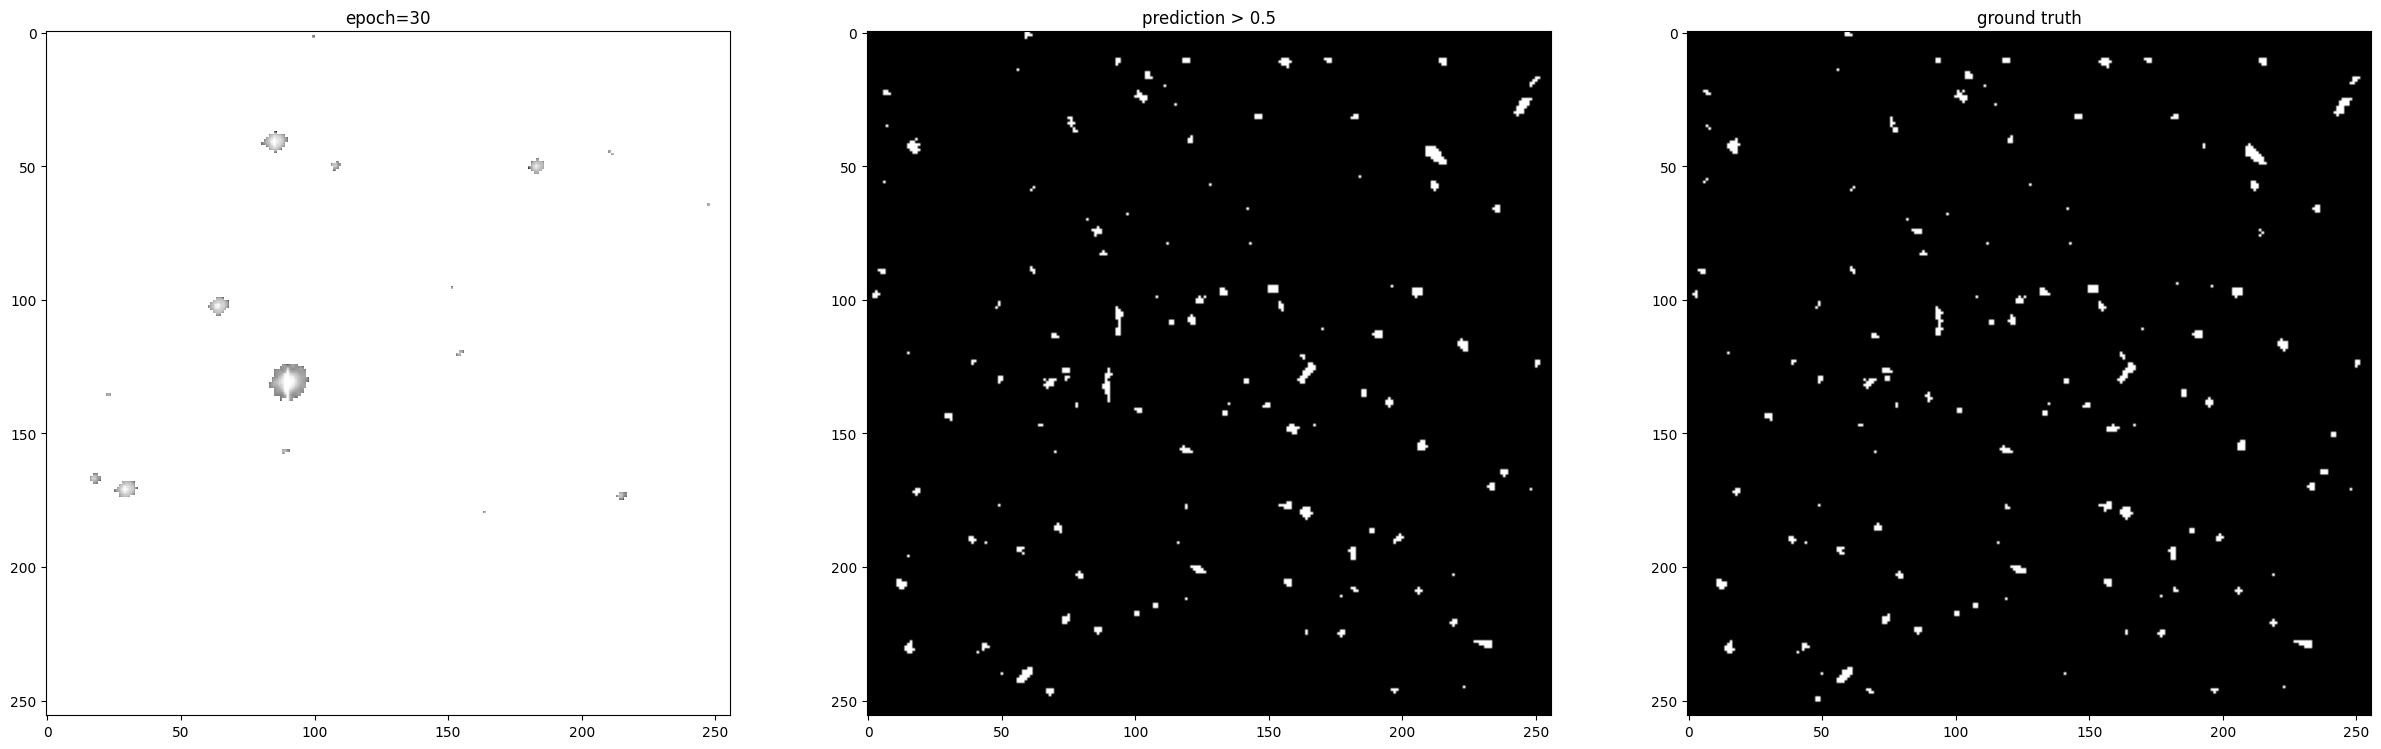

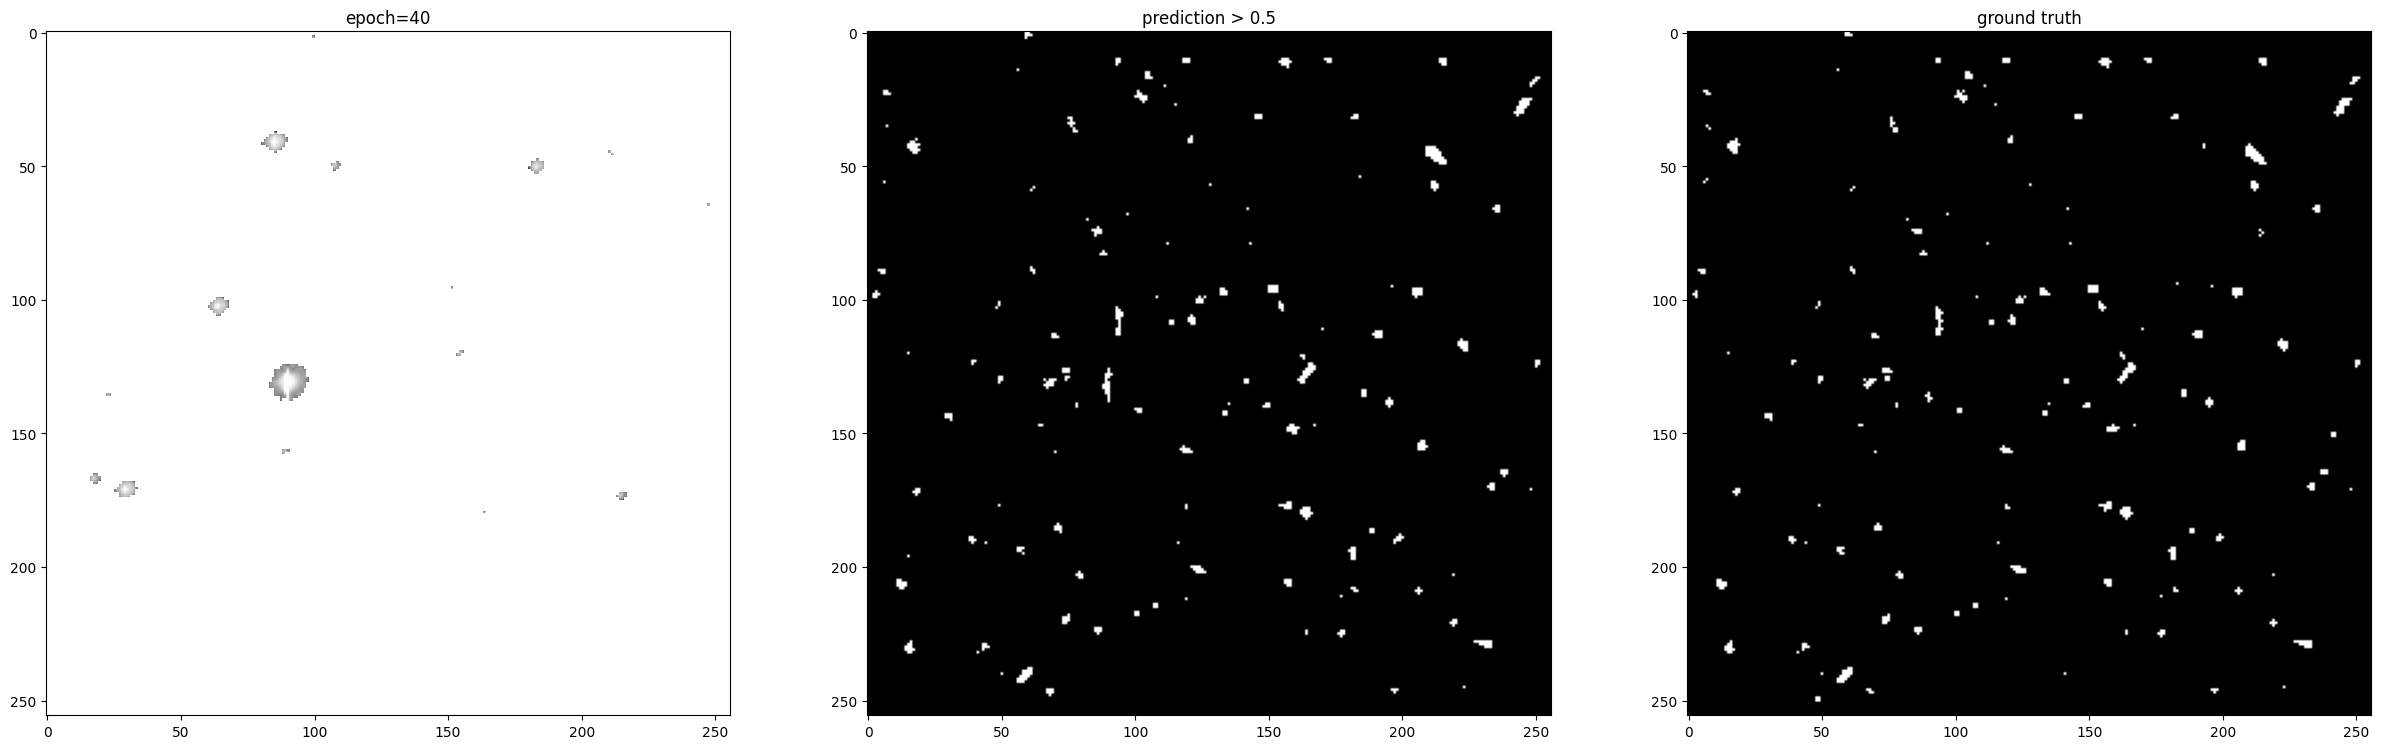

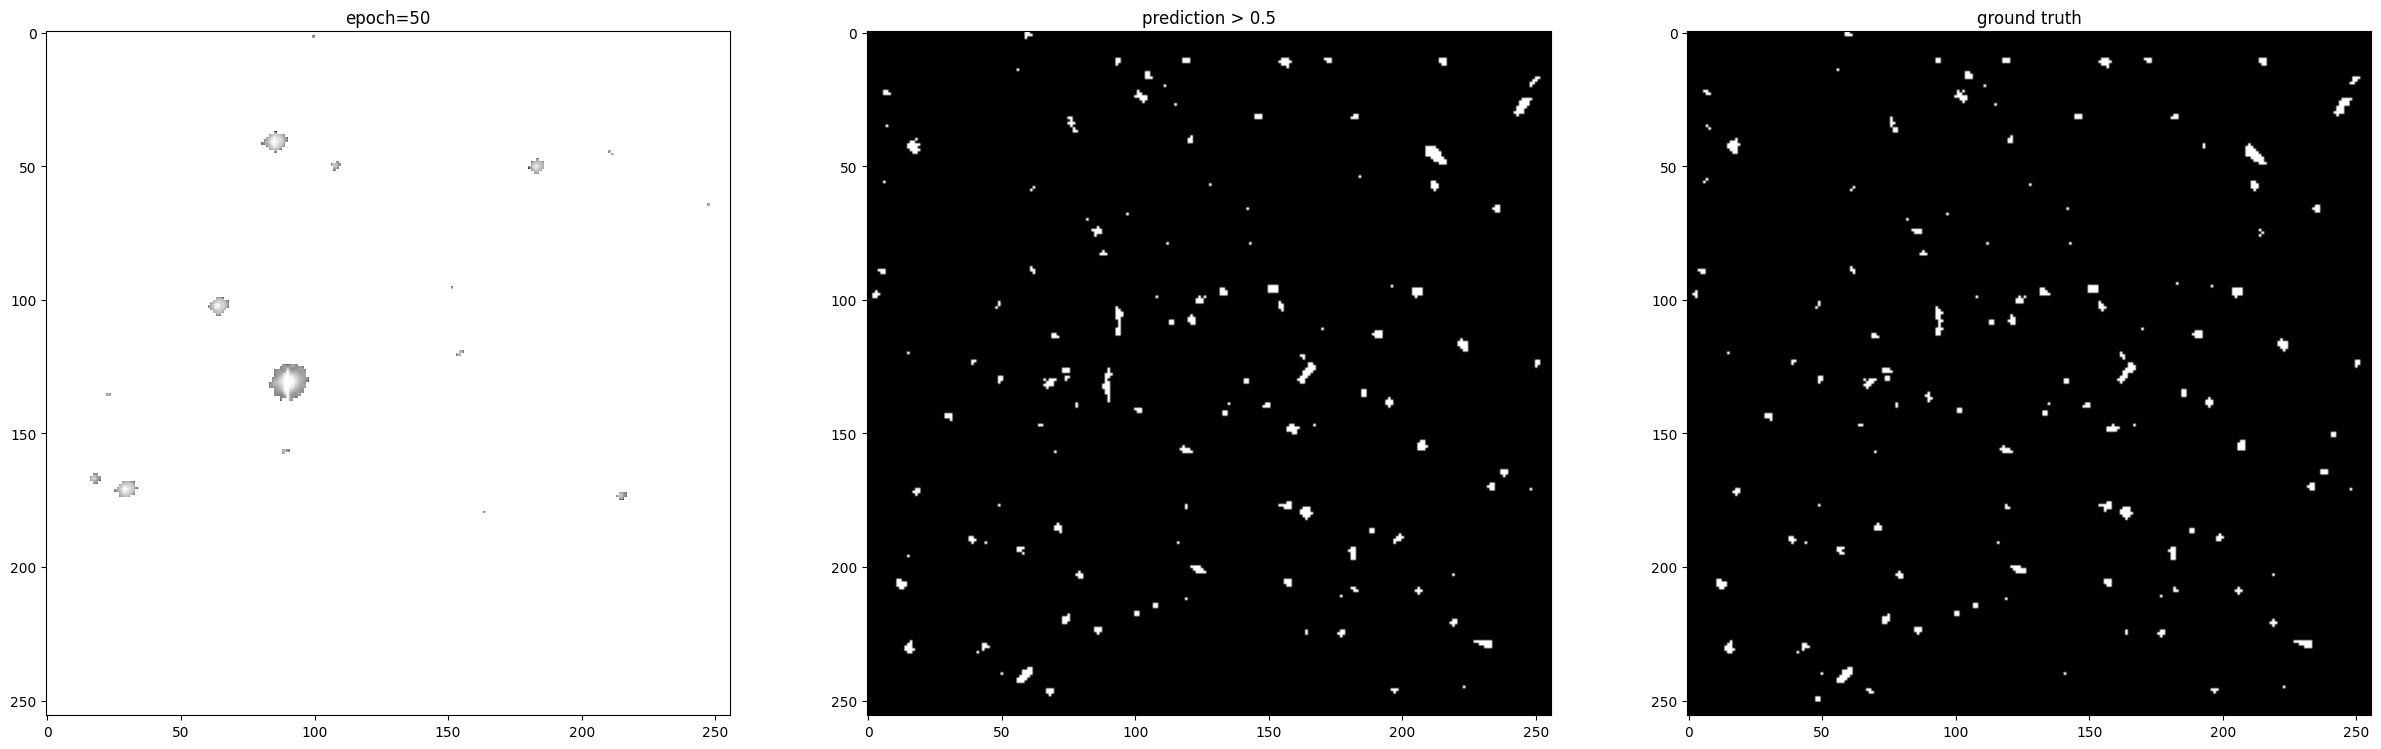

In [4]:
mdl_vi = model_train()

In [6]:
mdl_vi

'2025-11-29_ACS-WFC-VI1_epoch50'

#### Initialize model testing and Test the model

In [7]:

def model_test(mdl_path):
    """
    mdl_path: full path to the VI .pth file
    
    """
    test_dirs = np.load(os.path.join(base_dir, 'test_dirs.npy'), allow_pickle=True)

    field_type = {
        '10595_2': 'GC', '10595_7': 'GC',
        '9442_1': 'GC', '9442_3': 'GC', '9442_5': 'GC',
        '10760_2': 'GAL', '10760_4': 'GAL',
        '10631_3': 'EX', '10631_1': 'EX', '10631_4': 'EX',
        '12103_a3': 'EX', '13498_b1': 'EX',
        '13737_2': 'GAL', '13737_3': 'GAL',
        '9490_a3': 'GAL',
        '10349_30': 'GC', '10005_10': 'GC', '10120_3': 'GC',
        '12513_2': 'GAL', '12513_3': 'GAL',
        '14164_9': 'EX', '13718_6': 'EX',
        '10524_7': 'GC',
        '10182_pb': 'GAL', '10182_pd': 'GAL',
        '9425_2': 'EX', '9425_4': 'EX', '9583_99': 'EX',
        '10584_13': 'GAL', '9978_5e': 'EX',
        '15100_2': 'EX', '15647_13': 'EX',
        '11340_11': 'GC', '13389_10': 'EX', '9694_6': 'EX',
        '10342_3': 'GAL',
        '14343_1': 'GAL', '10536_13': 'EX',
        '13057_1': 'GAL', '10260_7': 'GAL', '10260_5': 'GAL',
        '10407_3': 'GAL',
        '13375_4': 'EX', '13375_7': 'EX',
        '13364_95': 'GAL',
        '10190_28': 'GAL', '10190_13': 'GAL',
        '10146_4': 'GC', '10146_3': 'GC',
        '10775_ab': 'GC', '11586_5': 'GC',
        '12438_1': 'EX', '13671_35': 'EX',
        '14164_1': 'GC',
        '9490_a2': 'GAL', '9405_6d': 'EX', '9405_4b': 'EX',
        '9450_14': 'EX', '10092_1': 'EX',
        '13691_11': 'GAL',
        '12058_12': 'GAL', '12058_16': 'GAL', '12058_1': 'GAL',
        '9450_16': 'EX',
        '10775_52': 'GC', '12602_1': 'GC', '12602_2': 'GC',
        '10775_29': 'GC', '10775_ad': 'GC',
        '12058_6': 'GAL',
        '14704_1': 'GAL',
        '13804_6': 'GAL'
    }

    f814_test_field_dirs = {'GC': [], 'EX': [], 'GAL': []}
    f606_test_field_dirs = {'GC': [], 'EX': [], 'GAL': []}
    f435_test_field_dirs = {'GC': [], 'EX': [], 'GAL': []}

    for _dir in test_dirs:
        arr = _dir.split('/')
        _filter = arr[-4]
        key = f'{arr[-3]}_{arr[-2]}'
        f_type = field_type[key]
        if _filter == 'f435w':
            f435_test_field_dirs[f_type].append(_dir)
        elif _filter == 'f606w':
            f606_test_field_dirs[f_type].append(_dir)
        elif _filter == 'f814w':
            f814_test_field_dirs[f_type].append(_dir)

    # ------------------------------------------------------------------
    # Instantiate VI model
    # ------------------------------------------------------------------
    print('------------------------------------------------------------')
    print('Model path:', mdl_path)
    print('------------------------------------------------------------')

    # mdl_path is already the full .pth path, so just pass it through
    global_mdl = deepCRVI(mask=mdl_path, device='GPU', hidden=32, n_samples=16)

    out_dir = os.path.join(base_dir, 'deepCR.ACS-WFC-VI1')
    os.makedirs(out_dir, exist_ok=True)

    # ----------------- F435W -----------------
    print('------------------------------------------------------------')
    print('Testing ACS/WFC VI model on F435W testset')
    print('Model path:', mdl_path)
    print('------------------------------------------------------------')

    for f_type in list(f435_test_field_dirs.keys()):
        filter_field_test_dirs = f435_test_field_dirs[f_type]
        tpr_fpr, tpr_fpr_dilate = roc(global_mdl, filter_field_test_dirs[::],
                                      mode='pair', dilate=True)

        tpr, fpr = tpr_fpr
        tpr_d, fpr_d = tpr_fpr_dilate
        fpr_d = fpr  # keep your existing convention

        np.save(os.path.join(out_dir, f'F435W_{f_type}_deepCR.ACS-WFC-VI1.npy'),
                [[tpr, fpr], [tpr_d, fpr_d]])

    # ----------------- F606W -----------------
    print('------------------------------------------------------------')
    print('Testing ACS/WFC VI model on F606W testset')
    print('------------------------------------------------------------')

    for f_type in list(f606_test_field_dirs.keys()):
        filter_field_test_dirs = f606_test_field_dirs[f_type]
        tpr_fpr, tpr_fpr_dilate = roc(global_mdl, filter_field_test_dirs[::],
                                      mode='pair', dilate=True)

        tpr, fpr = tpr_fpr
        tpr_d, fpr_d = tpr_fpr_dilate
        fpr_d = fpr

        np.save(os.path.join(out_dir, f'F606W_{f_type}_deepCR.ACS-WFC-VI1.npy'),
                [[tpr, fpr], [tpr_d, fpr_d]])

    # ----------------- F814W -----------------
    print('------------------------------------------------------------')
    print('Testing ACS/WFC VI model on F814W testset')
    print('------------------------------------------------------------')

    for f_type in list(f814_test_field_dirs.keys()):
        filter_field_test_dirs = f814_test_field_dirs[f_type]
        tpr_fpr, tpr_fpr_dilate = roc(global_mdl, filter_field_test_dirs[::],
                                      mode='pair', dilate=True)

        tpr, fpr = tpr_fpr
        tpr_d, fpr_d = tpr_fpr_dilate
        fpr_d = fpr

        np.save(os.path.join(out_dir, f'F814W_{f_type}_deepCR.ACS-WFC-VI1.npy'),
                [[tpr, fpr], [tpr_d, fpr_d]])

    del global_mdl
    return None


In [8]:
# mdl_vi_path = "/scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC/deepCR.ACS-WFC-VI/2025-11-28_ACS-WFC-VI_epoch5.pth"
model_test("/scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC/deepCR.ACS-WFC-VI1/2025-11-29_ACS-WFC-VI1_epoch50.pth")


------------------------------------------------------------
Model path: /scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC/deepCR.ACS-WFC-VI1/2025-11-29_ACS-WFC-VI1_epoch50.pth
------------------------------------------------------------
------------------------------------------------------------
Testing ACS/WFC VI model on F435W testset
Model path: /scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC/deepCR.ACS-WFC-VI1/2025-11-29_ACS-WFC-VI1_epoch50.pth
------------------------------------------------------------


100%|██████████| 420/420 [06:06<00:00,  1.15it/s]


------------------------------------------------------------
Testing ACS/WFC VI model on F606W testset
------------------------------------------------------------


100%|██████████| 1050/1050 [15:05<00:00,  1.16it/s]


------------------------------------------------------------
Testing ACS/WFC VI model on F814W testset
------------------------------------------------------------


100%|██████████| 1050/1050 [14:58<00:00,  1.17it/s]


#### Plotting ROC Curves

In [5]:
# Global variable for dilation control (still here if you want to use it later)
dilate = True  # Set to True for dilated, False for non-dilated


def plot_result():
    import seaborn as sns
    sns.set_theme(style="ticks", context='talk')

    # Ensure plot directory exists
    vi_plot_dir = os.path.join(base_dir, 'VI_plots1')
    if not os.path.exists(vi_plot_dir):
        os.makedirs(vi_plot_dir, exist_ok=True)

    print('------------------------------------------------------------')
    print('Plotting F435W testing result')
    print('------------------------------------------------------------')
    _plotter('F435W')

    print('------------------------------------------------------------')
    print('Plotting F606W testing result')
    print('------------------------------------------------------------')
    _plotter('F606W')

    print('------------------------------------------------------------')
    print('Plotting F814W testing result')
    print('------------------------------------------------------------')
    _plotter('F814W')

    return None


def _plotter(filter_name):
    fig, axs = plt.subplots(1, 3, figsize=(26, 6), sharey=True, sharex=True)
    fig.suptitle(f'{filter_name} Test Set', y=0.97, fontsize=20)

    vi_dir = os.path.join(base_dir, 'deepCR.ACS-WFC-VI1')

    tf_global_gc, tf_global_d_gc = np.load(
        os.path.join(vi_dir, f'{filter_name}_GC_deepCR.ACS-WFC-VI1.npy'),
        allow_pickle=True
    )
    tf_global_ex, tf_global_d_ex = np.load(
        os.path.join(vi_dir, f'{filter_name}_EX_deepCR.ACS-WFC-VI1.npy'),
        allow_pickle=True
    )
    tf_global_gal, tf_global_d_gal = np.load(
        os.path.join(vi_dir, f'{filter_name}_GAL_deepCR.ACS-WFC-VI1.npy'),
        allow_pickle=True
    )

    tf_global   = [tf_global_gc,  tf_global_ex,  tf_global_gal]
    tf_global_d = [tf_global_d_gc, tf_global_d_ex, tf_global_d_gal]

    titles = ['Globular Clusters', 'Extragalactic Fields', 'Resolved Galaxies']

    for i in range(3):
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('FPR [%]')
        axs[i].grid()
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(20, 100)

        # Get the data for without dilation and with dilation
        t_global, f_global = tf_global[i]
        t_global_d, f_global_d = tf_global_d[i]

        # Convert to numpy arrays and sort for proper interpolation
        f_global = np.array(f_global)
        t_global = np.array(t_global)
        sort_idx = np.argsort(f_global)
        sorted_f_global = f_global[sort_idx]
        sorted_t_global = t_global[sort_idx]

        f_global_d = np.array(f_global_d)
        t_global_d = np.array(t_global_d)
        sort_idx_d = np.argsort(f_global_d)
        sorted_f_global_d = f_global_d[sort_idx_d]
        sorted_t_global_d = t_global_d[sort_idx_d]

        # Compute TPR at FPR = 0.5 using interpolation
        tpr_no_dilate = np.interp(0.5, sorted_f_global,    sorted_t_global)
        tpr_dilate    = np.interp(0.5, sorted_f_global_d,  sorted_t_global_d)

        # Legend labels including the computed TPR values
        label_no_dilate = f'{filter_name} w/o dilate (TPR @0.5 FPR={tpr_no_dilate:.1f}%)'
        label_dilate    = f'{filter_name} with dilate (TPR @0.5 FPR={tpr_dilate:.1f}%)'

        # Plot without dilation (dashed black line)
        axs[i].plot(f_global,   t_global,   label=label_no_dilate, ls='-.', c='k')

        # Plot with dilation (solid red line)
        axs[i].plot(f_global_d, t_global_d, label=label_dilate,    c='r', ls='-')

        axs[i].legend(frameon=False, loc='lower right')

    axs[0].set_ylabel('TPR [%]')

    # Save the figure
    fig.savefig(os.path.join(base_dir, 'VI_plots', f'{filter_name}.pdf'),
                format='pdf', bbox_inches='tight')

    # plt.close(fig)
    plt.show()
    return None


------------------------------------------------------------
Plotting F435W testing result
------------------------------------------------------------


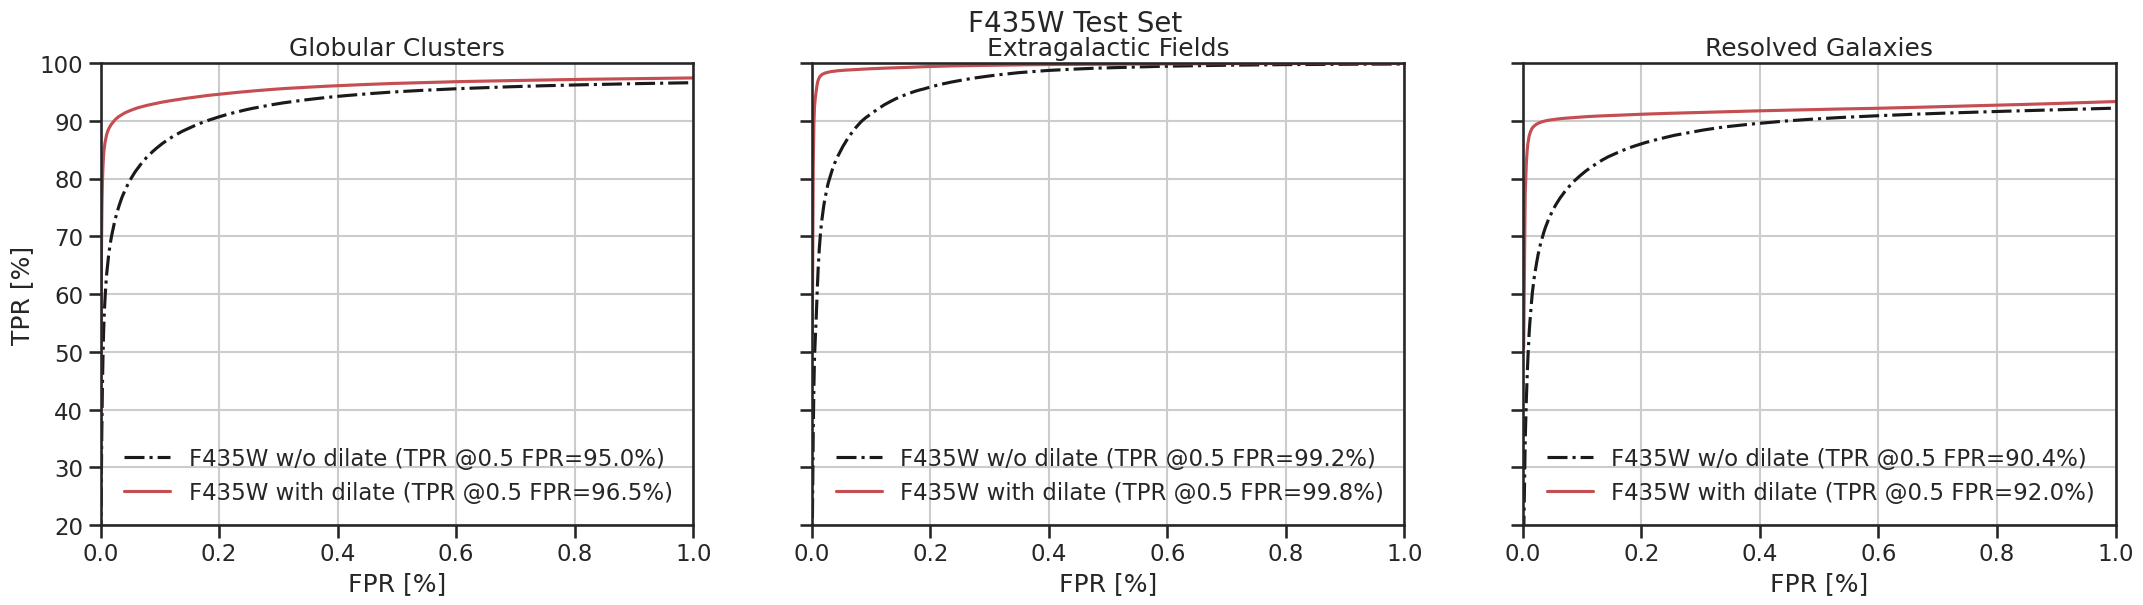

------------------------------------------------------------
Plotting F606W testing result
------------------------------------------------------------


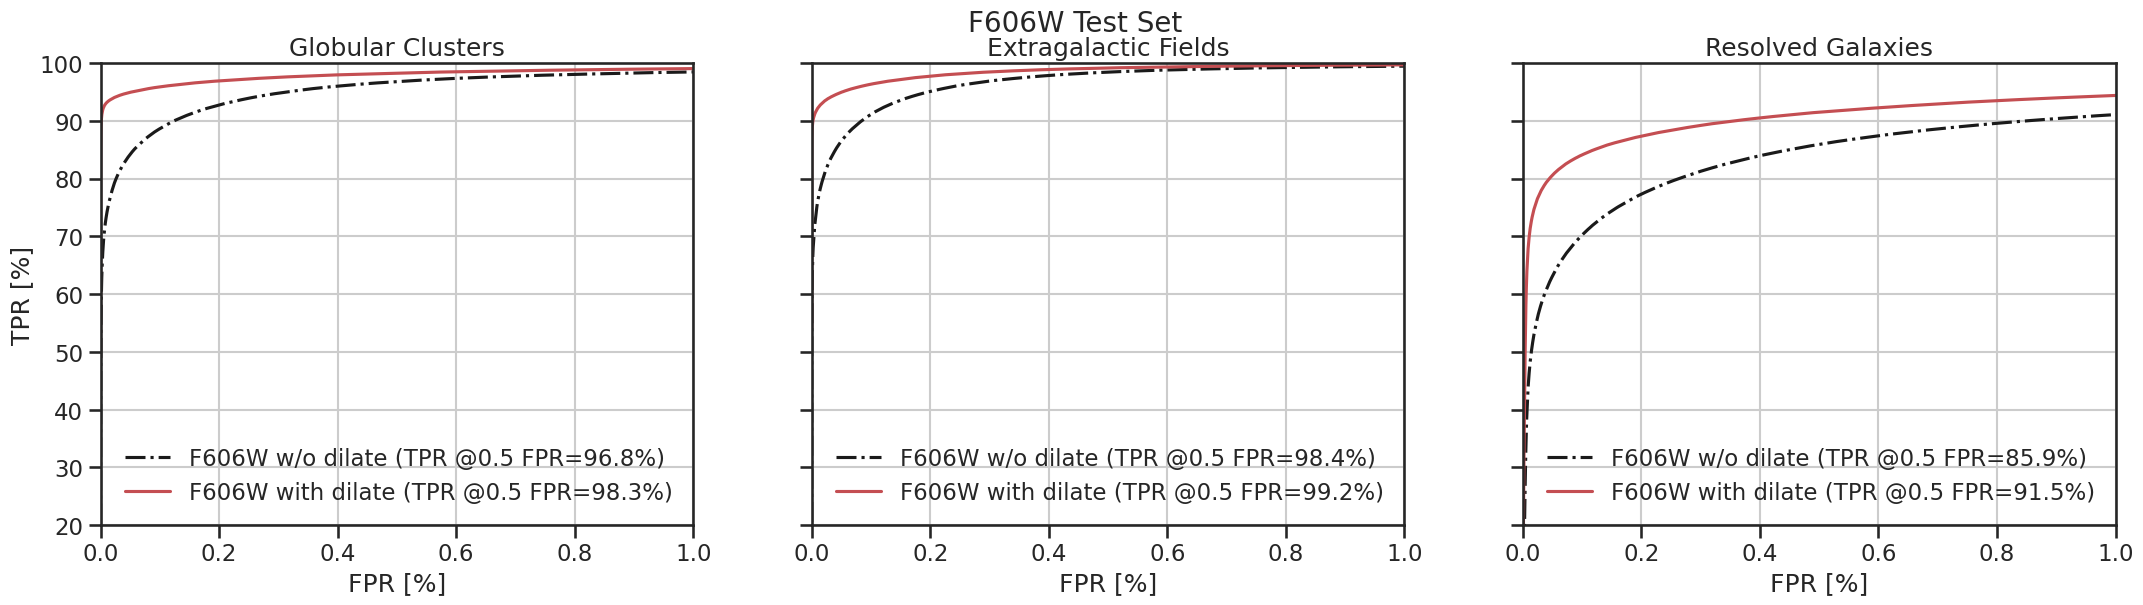

------------------------------------------------------------
Plotting F814W testing result
------------------------------------------------------------


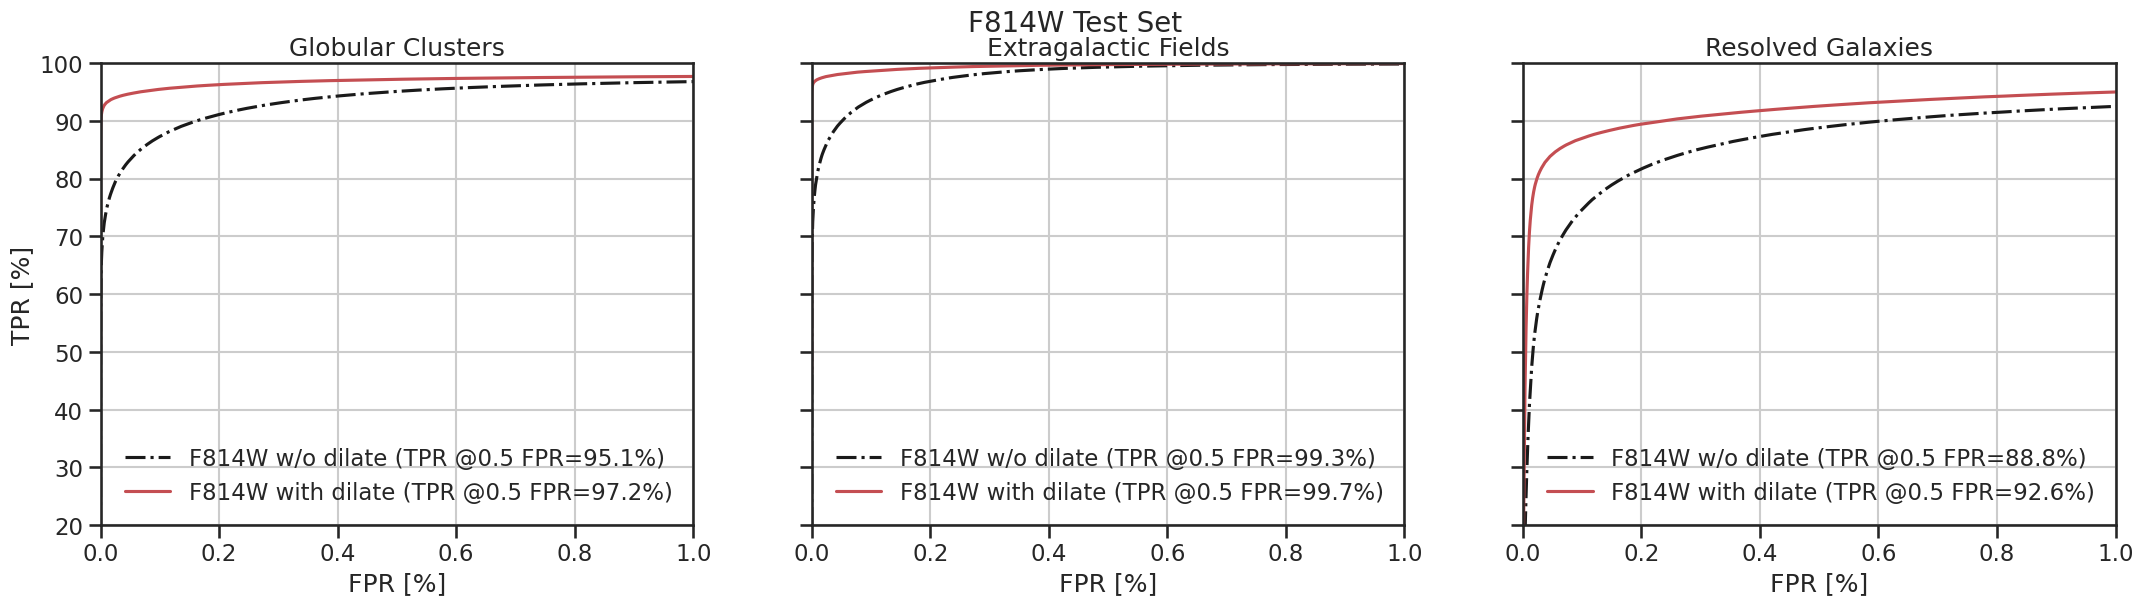

In [6]:
plot_result()


#### Other metrics

In [7]:
model_path = "/scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC/deepCR.ACS-WFC-VI1/2025-11-29_ACS-WFC-VI1_epoch50.pth"
model = deepCRVI(mask=model_path, device="GPU", hidden=32, n_samples=16)


In [8]:
test_dirs = np.load(os.path.join(base_dir, 'test_dirs.npy'), allow_pickle=True)

field_type = {
        '10595_2': 'GC', '10595_7': 'GC',
        '9442_1': 'GC', '9442_3': 'GC', '9442_5': 'GC',
        '10760_2': 'GAL', '10760_4': 'GAL',
        '10631_3': 'EX', '10631_1': 'EX', '10631_4': 'EX',
        '12103_a3': 'EX', '13498_b1': 'EX',
        '13737_2': 'GAL', '13737_3': 'GAL',
        '9490_a3': 'GAL',
        '10349_30': 'GC', '10005_10': 'GC', '10120_3': 'GC',
        '12513_2': 'GAL', '12513_3': 'GAL',
        '14164_9': 'EX', '13718_6': 'EX',
        '10524_7': 'GC',
        '10182_pb': 'GAL', '10182_pd': 'GAL',
        '9425_2': 'EX', '9425_4': 'EX', '9583_99': 'EX',
        '10584_13': 'GAL', '9978_5e': 'EX',
        '15100_2': 'EX', '15647_13': 'EX',
        '11340_11': 'GC', '13389_10': 'EX', '9694_6': 'EX',
        '10342_3': 'GAL',
        '14343_1': 'GAL', '10536_13': 'EX',
        '13057_1': 'GAL', '10260_7': 'GAL', '10260_5': 'GAL',
        '10407_3': 'GAL',
        '13375_4': 'EX', '13375_7': 'EX',
        '13364_95': 'GAL',
        '10190_28': 'GAL', '10190_13': 'GAL',
        '10146_4': 'GC', '10146_3': 'GC',
        '10775_ab': 'GC', '11586_5': 'GC',
        '12438_1': 'EX', '13671_35': 'EX',
        '14164_1': 'GC',
        '9490_a2': 'GAL', '9405_6d': 'EX', '9405_4b': 'EX',
        '9450_14': 'EX', '10092_1': 'EX',
        '13691_11': 'GAL',
        '12058_12': 'GAL', '12058_16': 'GAL', '12058_1': 'GAL',
        '9450_16': 'EX',
        '10775_52': 'GC', '12602_1': 'GC', '12602_2': 'GC',
        '10775_29': 'GC', '10775_ad': 'GC',
        '12058_6': 'GAL',
        '14704_1': 'GAL',
        '13804_6': 'GAL'
}

f814_test_field_dirs = {'GC': [], 'EX': [], 'GAL': []}
f606_test_field_dirs = {'GC': [], 'EX': [], 'GAL': []}
f435_test_field_dirs = {'GC': [], 'EX': [], 'GAL': []}

# Build per-filter, per-field-type test dir lists
for _dir in test_dirs:
    arr = _dir.split('/')
    _filter = arr[-4]
    key = f'{arr[-3]}_{arr[-2]}'

    # Safely look up field type; skip if not present
    f_type = field_type.get(key, None)
    if f_type is None:
        # Optional: uncomment for debugging
        # print(f"[WARNING] Skipping unknown field: {key} from {_dir}")
        continue

    if _filter == 'f435w':
        f435_test_field_dirs[f_type].append(_dir)
    elif _filter == 'f606w':
        f606_test_field_dirs[f_type].append(_dir)
    elif _filter == 'f814w':
        f814_test_field_dirs[f_type].append(_dir)

    

[VI] F435W Globular Clusters – Brier: 0.0017, NLL: 0.0072, ECE: 0.0007
[VI] F435W Extragalactic Fields – Brier: 0.0015, NLL: 0.0053, ECE: 0.0009
[VI] F435W Resolved Galaxies – Brier: 0.0035, NLL: 0.0173, ECE: 0.0023
[VI] F606W Globular Clusters – Brier: 0.0023, NLL: 0.0083, ECE: 0.0005
[VI] F606W Extragalactic Fields – Brier: 0.0014, NLL: 0.0049, ECE: 0.0008
[VI] F606W Resolved Galaxies – Brier: 0.0037, NLL: 0.0143, ECE: 0.0008
[VI] F814W Globular Clusters – Brier: 0.0028, NLL: 0.0133, ECE: 0.0016
[VI] F814W Extragalactic Fields – Brier: 0.0016, NLL: 0.0054, ECE: 0.0015
[VI] F814W Resolved Galaxies – Brier: 0.0032, NLL: 0.0127, ECE: 0.0019


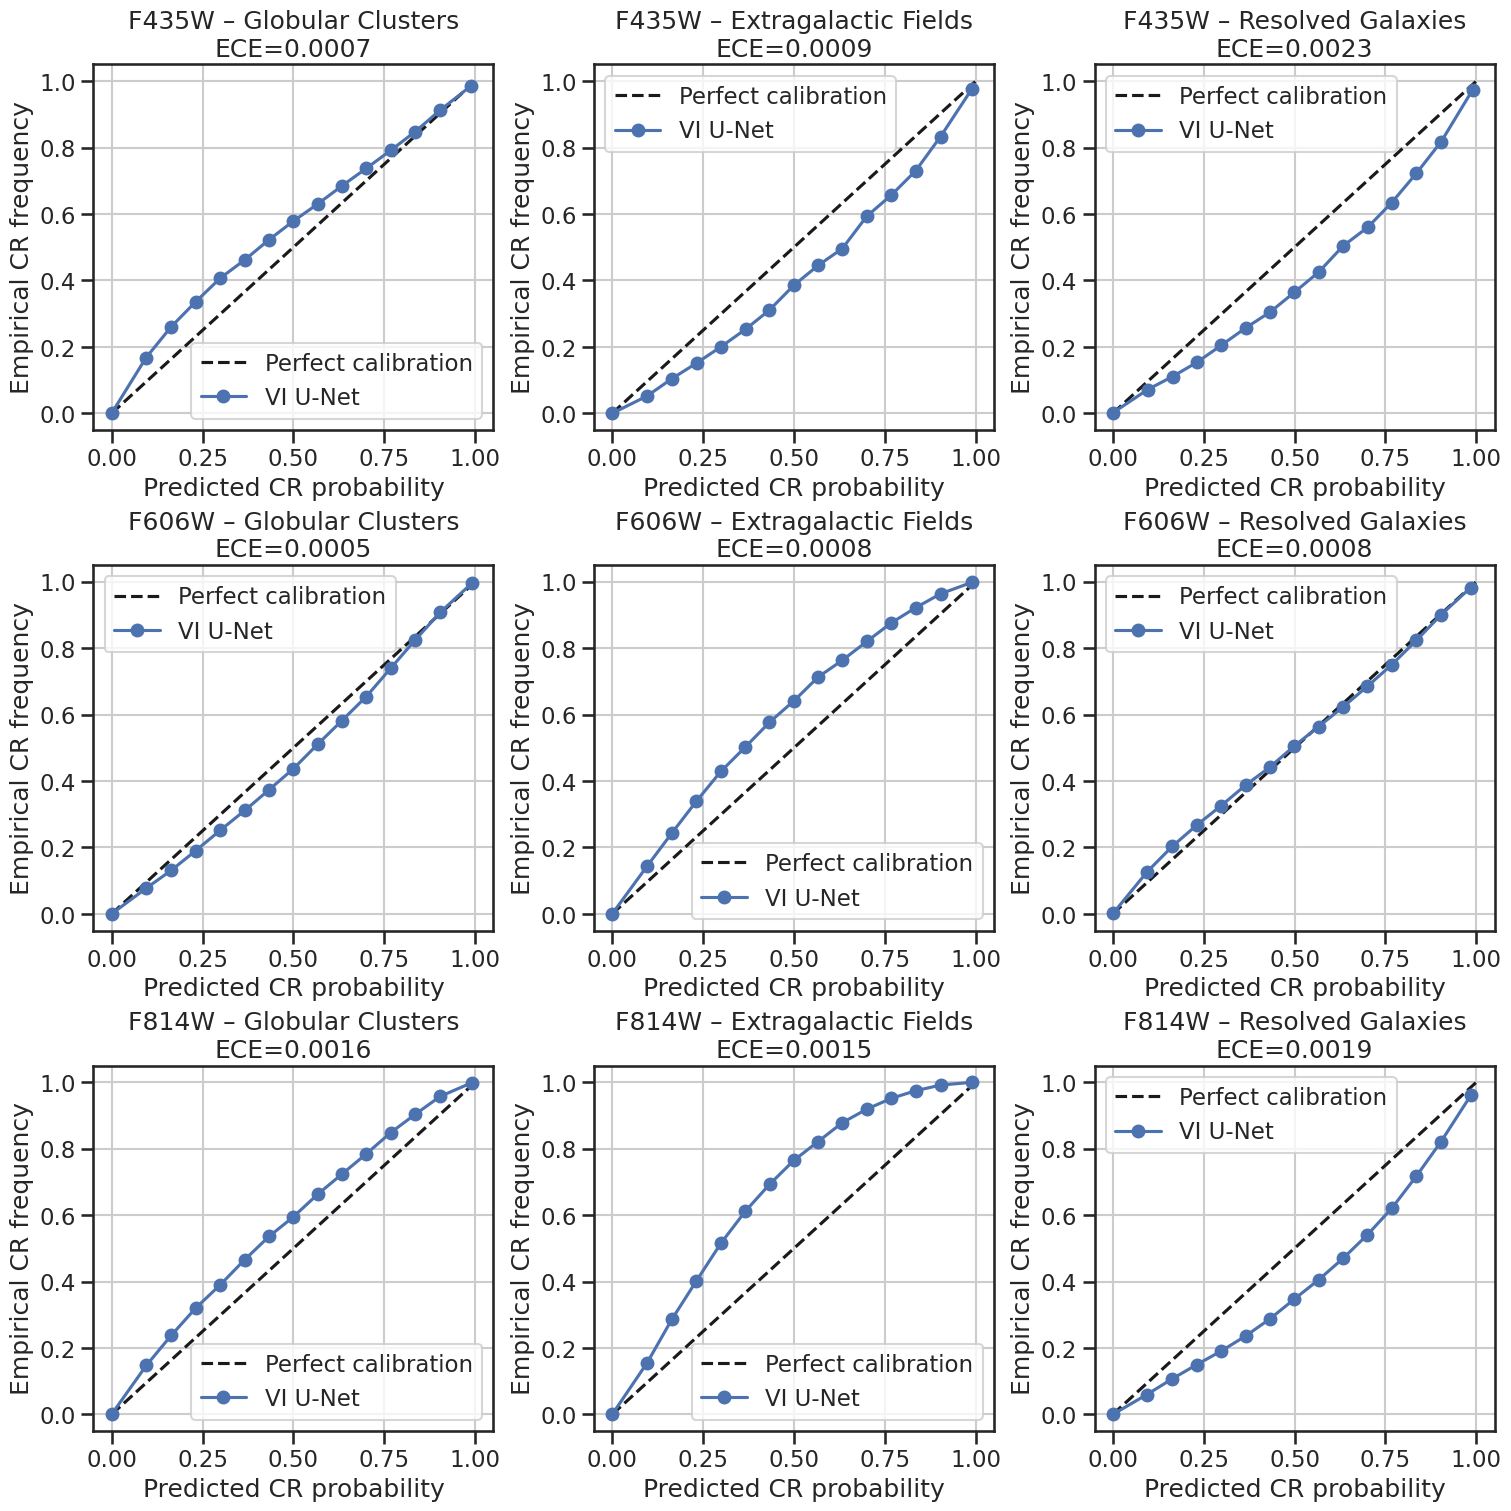

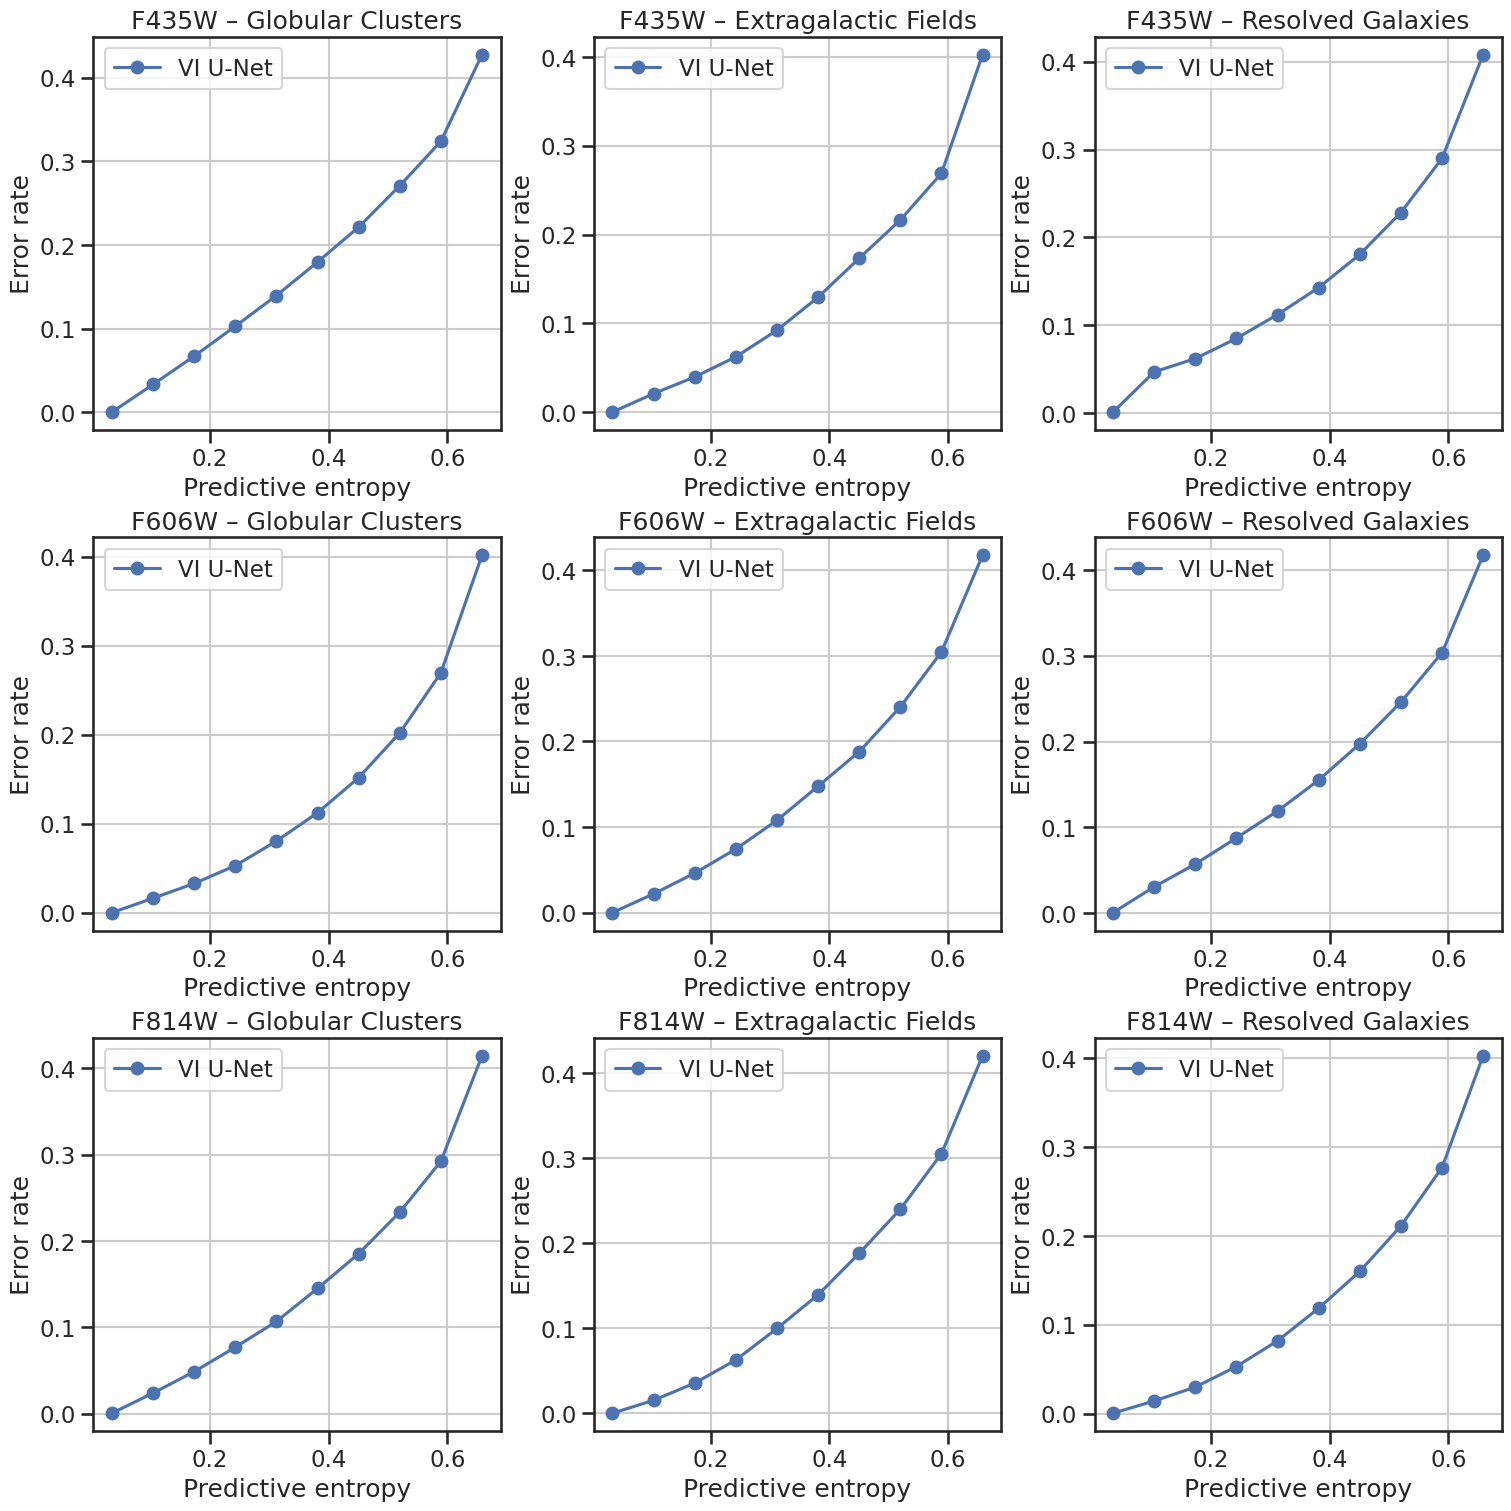

In [9]:
from vi_metrics import (
    plot_vi_reliability_grid,
    plot_vi_error_entropy_grid,
    plot_vi_risk_coverage_grid,
)

# Reliability 3x3 grid (VI)
fig_rel_vi, axes_rel_vi = plot_vi_reliability_grid(
    model,
    f435_test_field_dirs,
    f606_test_field_dirs,
    f814_test_field_dirs,
)
fig_rel_vi.savefig("vi_reliability_grid1.pdf", bbox_inches="tight")

# Error vs entropy 3x3 grid (VI)
fig_err_vi, axes_err_vi = plot_vi_error_entropy_grid(
    model,
    f435_test_field_dirs,
    f606_test_field_dirs,
    f814_test_field_dirs,
    threshold=0.5,
    n_bins=10,
)
fig_err_vi.savefig("vi_error_entropy_grid1.pdf", bbox_inches="tight")

# Risk–coverage 3x3 grid (VI)
# fig_rc_vi, axes_rc_vi = plot_vi_risk_coverage_grid(
#     model,
#     f435_test_field_dirs,
#     f606_test_field_dirs,
#     f814_test_field_dirs,
#     threshold=0.5,
# )
# fig_rc_vi.savefig("vi_risk_coverage_grid_3x3.pdf", bbox_inches="tight")


In [10]:
from astropy.io import fits

image = fits.getdata("jdba2sooq_flc.fits")[256:256+256, 4096-256:4096]

# 4. Binary CR mask at threshold 0.5 (same as classic deepCR)
mask = model.clean(image, threshold=0.5)

# 5. Probabilistic mask (mean CR probability per pixel)
prob_mask = model.clean(image, binary=False)

# 6. Optional inpainting (median scheme, like your base wrapper)
mask, cleaned_image = model.clean(image, threshold=0.5, inpaint=True)

# 7. Uncertainty map (predictive entropy) from last call
entropy_map = model.last_entropy  # shape ~ (H, W)


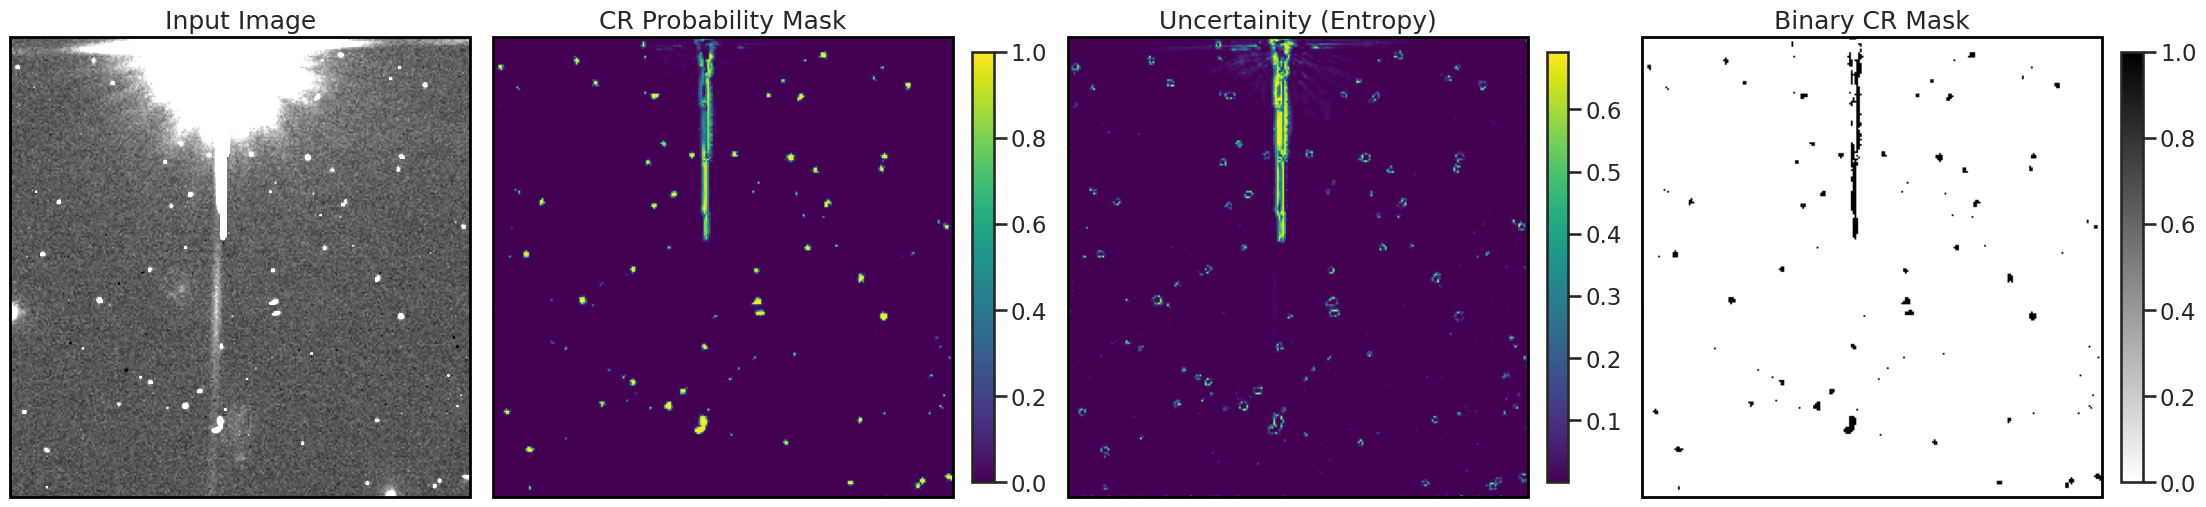

In [13]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval, ImageNormalize

fig, axes = plt.subplots(
    1, 4,
    figsize=(22, 5),
    constrained_layout=True      # <-- change this to True (or use layout='constrained')
)

interval = ZScaleInterval()
vmin_img, vmax_img = interval.get_limits(image)
norm_img = ImageNormalize(vmin=vmin_img, vmax=vmax_img)

def add_clean_border(ax):
    ax.add_patch(
        Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            fill=False,
            edgecolor='black',
            linewidth=2,
            clip_on=False
        )
    )

# 1) Input image
axes[0].imshow(image, cmap='gray', norm=norm_img)
axes[0].set_title('Input Image')
axes[0].axis('off')
add_clean_border(axes[0])

# 2) Prob. mask
im1 = axes[1].imshow(prob_mask, cmap='viridis', vmin=0.0, vmax=1.0)
axes[1].set_title('CR Probability Mask')
axes[1].axis('off')
add_clean_border(axes[1])
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3) Uncertainty
im2 = axes[2].imshow(entropy_map, cmap='viridis')
axes[2].set_title('Uncertainity (Entropy)')
axes[2].axis('off')
add_clean_border(axes[2])
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# 4) Mask
im3 = axes[3].imshow(mask, cmap='binary')
axes[3].set_title('Binary CR Mask')
axes[3].axis('off')
add_clean_border(axes[3])
fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
# plt.savefig('vi_qualitative_4plots1.png', dpi=300)
fig.savefig("vi_qualitative_4plots1.pdf", bbox_inches="tight")

plt.show()
